In [1]:
# --------------------------------------------------
# Import Libraries and Set Up Environment
# --------------------------------------------------
import os
import pandas as pd
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import parallel_backend

matplotlib.use('Agg')  # Use 'Agg' backend

# Enable inline plotting
%matplotlib inline

# Set joblib temporary directory
os.environ['JOBLIB_TEMP_FOLDER'] = '/home/nrelab-titan/Desktop/shovon/temp_joblib'

In [2]:
# --------------------------------------------------
# Load and Prepare Data
# --------------------------------------------------
# File paths
plain_terrain_file = '/home/nrelab-titan/Desktop/shovon/data/terrain_analysis/plain_terrain_features.csv'
grass_terrain_file = '/home/nrelab-titan/Desktop/shovon/data/terrain_analysis/grass_terrain_features.csv'

# Load CSV files
plain_terrain_df = pd.read_csv(plain_terrain_file)
grass_terrain_df = pd.read_csv(grass_terrain_file)

plain_terrain_df['label'] = 'plain'
grass_terrain_df['label'] = 'grass'

# Concatenate the DataFrames
combined_df = pd.concat([plain_terrain_df, grass_terrain_df], ignore_index=True)

# Verify the combined DataFrame
print(combined_df.head())


         X         Y         Z   NormalX   NormalY   NormalZ  Intensity  label
0  1.89208 -0.283757 -0.594149  0.054079 -0.063316  0.996527    36.1429  plain
1  1.96072 -0.267909 -0.599250  0.058089 -0.063021  0.996320    35.8889  plain
2  1.91002 -0.202749 -0.590134  0.058065 -0.063081  0.996318    36.0000  plain
3  1.98394 -0.209456 -0.604023  0.064656 -0.062046  0.995977    36.0000  plain
4  1.94386 -0.077196 -0.588291  0.081759 -0.059133  0.994896    36.0000  plain


In [3]:
# --------------------------------------------------
# Feature Extraction and Scaling
# --------------------------------------------------
# Features and labels
features = ['NormalX', 'NormalY']
X = combined_df[features]
y = combined_df['label'].map({'plain': 0, 'grass': 1})

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [4]:
# --------------------------------------------------
# Model Training and Cross-Validation
# --------------------------------------------------
# Initialize LinearSVC
svm = LinearSVC(random_state=42)

# Perform 5-fold cross-validation with parallel processing
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def parallel_cross_val_predict(estimator, X, y, cv, method='predict'):
    with parallel_backend('loky'):
        return cross_val_predict(estimator, X, y, cv=cv, method=method, n_jobs=-1)

# Using parallel processing for cross_val_predict
y_pred = parallel_cross_val_predict(svm, X_scaled, y, skf)
y_decision = parallel_cross_val_predict(svm, X_scaled, y, skf, method='decision_function')

/home/nrelab-titan/Desktop/shovon/.venv/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/nrelab-titan/Desktop/shovon/.venv/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/nrelab-titan/Desktop/shovon/.venv/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/nrelab-titan/Desktop/shovon/.venv/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to

In [5]:
# --------------------------------------------------
# Calculate and Print Metrics
# --------------------------------------------------
# Calculate metrics
accuracy = accuracy_score(y, y_pred)
f1 = f1_score(y, y_pred)
roc_auc = roc_auc_score(y, y_decision)

# Compute TPR, FPR
fpr, tpr, thresholds = roc_curve(y, y_decision)

# Confusion matrix
cm = confusion_matrix(y, y_pred)
tn, fp, fn, tp = cm.ravel()

# Calculate additional metrics
tpr_value = tp / (tp + fn)  # True Positive Rate (Recall)
fpr_value = fp / (fp + tn)  # False Positive Rate

# Print metrics
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"AUC: {roc_auc}")
print(f"TPR: {tpr_value}")
print(f"FPR: {fpr_value}")
print("\nConfusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(y, y_pred, target_names=['plain', 'grass']))


Accuracy: 0.9947625077986523
F1 Score: 0.9954330249803309
AUC: 0.9998428362362751
TPR: 0.994548437287681
FPR: 0.004949144899762543

Confusion Matrix:
[[ 820908    4083]
 [   6058 1105183]]

Classification Report:
              precision    recall  f1-score   support

       plain       0.99      1.00      0.99    824991
       grass       1.00      0.99      1.00   1111241

    accuracy                           0.99   1936232
   macro avg       0.99      0.99      0.99   1936232
weighted avg       0.99      0.99      0.99   1936232



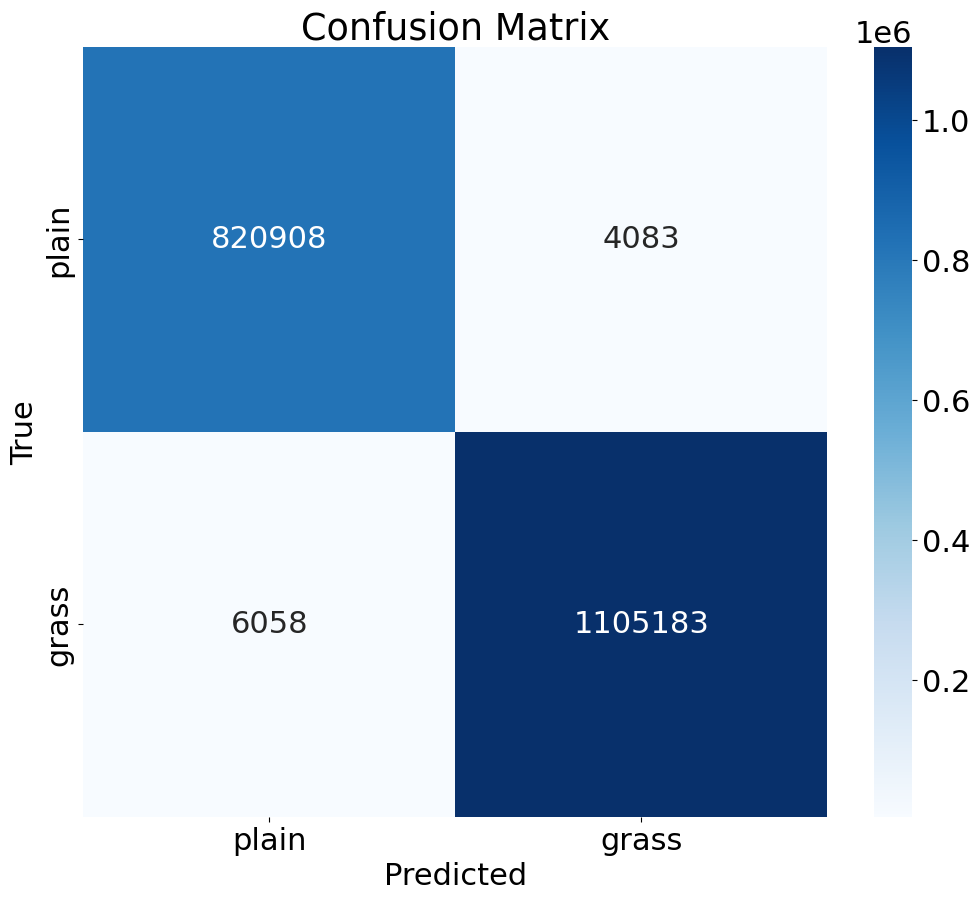

In [6]:
# --------------------------------------------------
# Plot Confusion Matrix
# --------------------------------------------------
# Set the directory where you want to save the plots
plot_save_dir = '/home/nrelab-titan/Desktop/shovon/plots/'

# Ensure the directory exists
os.makedirs(plot_save_dir, exist_ok=True)

# Increase text size for plots
plt.rcParams.update({'font.size': 22})

# Plot Confusion Matrix using Seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['plain', 'grass'], yticklabels=['plain', 'grass'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
confusion_matrix_path = os.path.join(plot_save_dir, 'confusion_matrix.png')
plt.savefig(confusion_matrix_path)
plt.show()

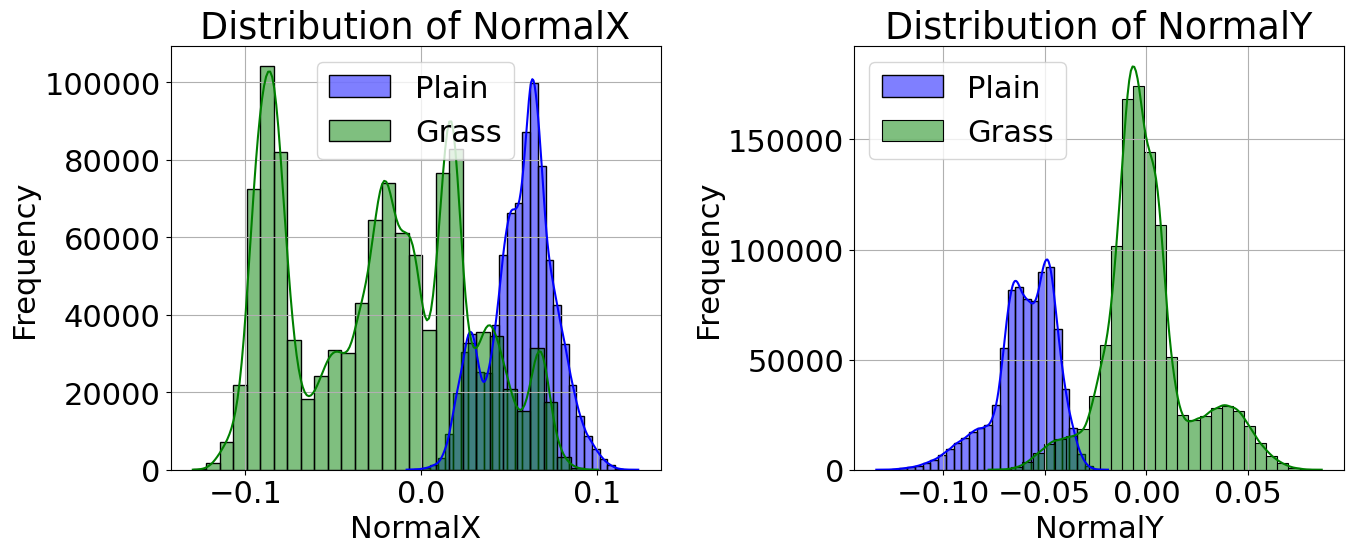

In [7]:
# Plot side by side histograms for NormalX
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(plain_terrain_df['NormalX'], kde=True, bins=30, color='blue', label='Plain')
sns.histplot(grass_terrain_df['NormalX'], kde=True, bins=30, color='green', label='Grass')
plt.title('Distribution of NormalX')
plt.xlabel('NormalX')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)

# Plot side by side histograms for NormalY
plt.subplot(1, 2, 2)
sns.histplot(plain_terrain_df['NormalY'], kde=True, bins=30, color='blue', label='Plain')
sns.histplot(grass_terrain_df['NormalY'], kde=True, bins=30, color='green', label='Grass')
plt.title('Distribution of NormalY')
plt.xlabel('NormalY')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


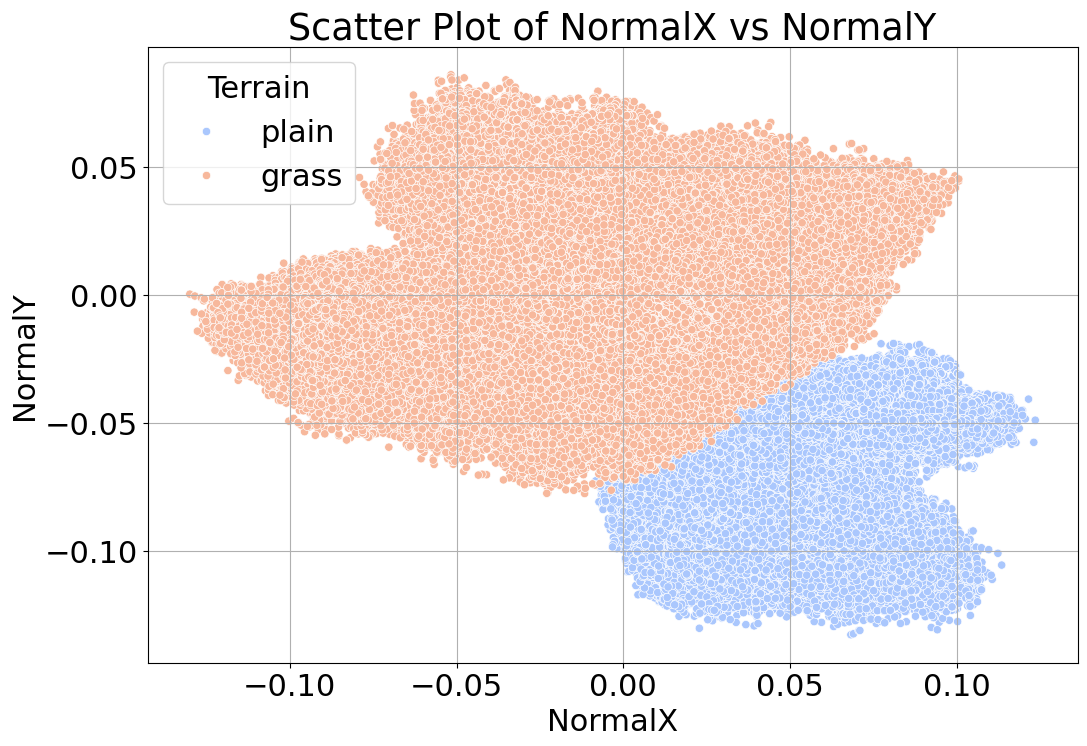

In [8]:
# Scatter Plot for NormalX vs NormalY
plt.figure(figsize=(12, 8))
sns.scatterplot(x='NormalX', y='NormalY', hue='label', data=combined_df, palette='coolwarm')
plt.title('Scatter Plot of NormalX vs NormalY')
plt.xlabel('NormalX')
plt.ylabel('NormalY')
plt.legend(title='Terrain')
plt.grid(True)
plt.show()

In [9]:
def add_gaussian_noise(data, std_dev, noise_level=1.0):
    noise = np.random.normal(0, std_dev * noise_level, data.shape)
    return data + noise

# Define the noise level (this parameter can be adjusted)
noise_level = 0.5  # Adjust this value to control the amount of noise

# Calculate standard deviation for NormalX and NormalY separately for plain and grass
plain_std_X = plain_terrain_df['NormalX'].std()
plain_std_Y = plain_terrain_df['NormalY'].std()

grass_std_X = grass_terrain_df['NormalX'].std()
grass_std_Y = grass_terrain_df['NormalY'].std()

# Add Gaussian noise to the plain data
plain_terrain_df['NormalX_noisy'] = add_gaussian_noise(plain_terrain_df['NormalX'], plain_std_X, noise_level)
plain_terrain_df['NormalY_noisy'] = add_gaussian_noise(plain_terrain_df['NormalY'], plain_std_Y, noise_level)

# Add Gaussian noise to the grass data
grass_terrain_df['NormalX_noisy'] = add_gaussian_noise(grass_terrain_df['NormalX'], grass_std_X, noise_level)
grass_terrain_df['NormalY_noisy'] = add_gaussian_noise(grass_terrain_df['NormalY'], grass_std_Y, noise_level)

# Concatenate the DataFrames with noisy data
combined_noisy_df = pd.concat([plain_terrain_df, grass_terrain_df], ignore_index=True)

# Verify the combined DataFrame with noise
print(combined_noisy_df.head())

         X         Y         Z   NormalX   NormalY   NormalZ  Intensity  \
0  1.89208 -0.283757 -0.594149  0.054079 -0.063316  0.996527    36.1429   
1  1.96072 -0.267909 -0.599250  0.058089 -0.063021  0.996320    35.8889   
2  1.91002 -0.202749 -0.590134  0.058065 -0.063081  0.996318    36.0000   
3  1.98394 -0.209456 -0.604023  0.064656 -0.062046  0.995977    36.0000   
4  1.94386 -0.077196 -0.588291  0.081759 -0.059133  0.994896    36.0000   

   label  NormalX_noisy  NormalY_noisy  
0  plain       0.055189      -0.055189  
1  plain       0.066832      -0.051372  
2  plain       0.056163      -0.066699  
3  plain       0.077078      -0.061276  
4  plain       0.080264      -0.050615  


In [10]:
# Plot scatter plots for Noisy NormalX vs Noisy NormalY for both labels

# Scatter Plot for NormalX vs NormalY
plt.figure(figsize=(12, 8))
sns.scatterplot(x='NormalX', y='NormalY', hue='label', data=combined_df, palette='coolwarm')
plt.title('Scatter Plot of NormalX vs NormalY')
plt.xlabel('NormalX')
plt.ylabel('NormalY')
plt.legend(title='Terrain')
plt.grid(True)
plt.show()

# Prepare the noisy data
X_noisy = combined_noisy_df[['NormalX_noisy', 'NormalY_noisy']]
y_noisy = combined_noisy_df['label'].map({'plain': 0, 'grass': 1})


plt.figure(figsize=(14, 8))
sns.scatterplot(x='NormalX_noisy', y='NormalY_noisy', hue='label', data=combined_noisy_df, palette='coolwarm')
plt.title('Scatter Plot of Noisy NormalX vs Noisy NormalY')
plt.xlabel('NormalX_noisy')
plt.ylabel('NormalY_noisy')
plt.legend(title='Terrain')
plt.grid(True)
plt.show()

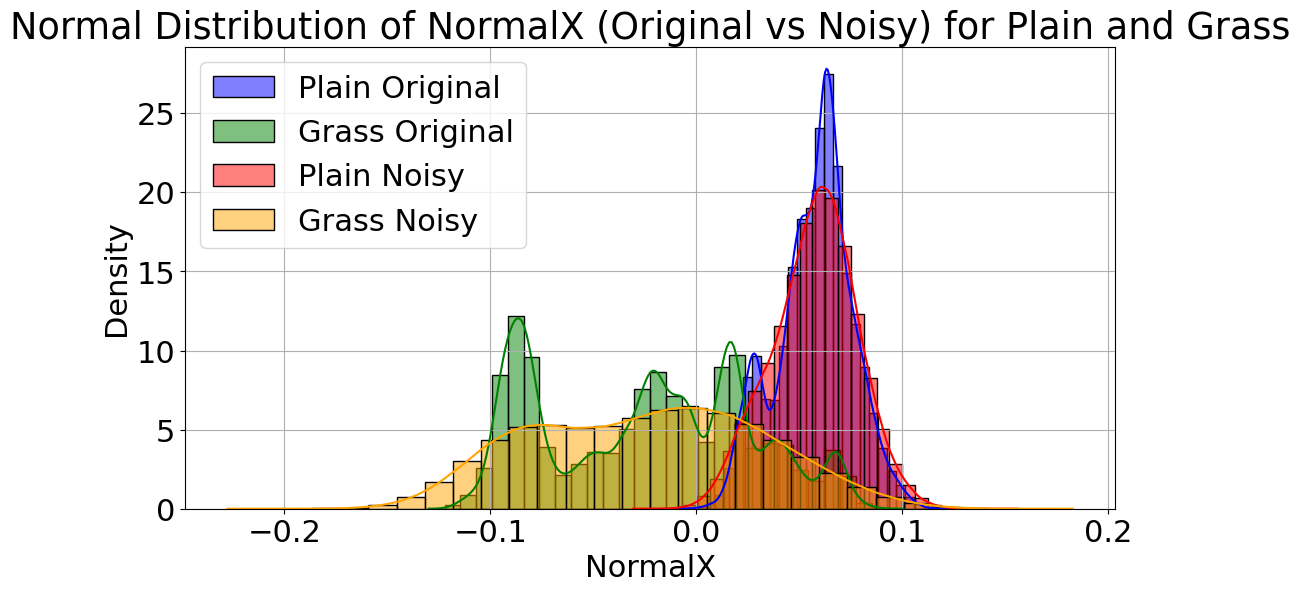

In [ ]:
# Plot histograms with KDE for NormalX and NormalX_noisy
plt.figure(figsize=(12, 6))

# Original NormalX for Plain and Grass
sns.histplot(plain_terrain_df['NormalX'], kde=True, bins=30, color='blue', label='Plain Original', stat='density')
sns.histplot(grass_terrain_df['NormalX'], kde=True, bins=30, color='green', label='Grass Original', stat='density')

# Noisy NormalX for Plain and Grass
sns.histplot(plain_terrain_df['NormalX_noisy'], kde=True, bins=30, color='red', label='Plain Noisy', stat='density', alpha=0.5)
sns.histplot(grass_terrain_df['NormalX_noisy'], kde=True, bins=30, color='orange', label='Grass Noisy', stat='density', alpha=0.5)

plt.title('Normal Distribution of NormalX (Original vs Noisy) for Plain and Grass')
plt.xlabel('NormalX')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()


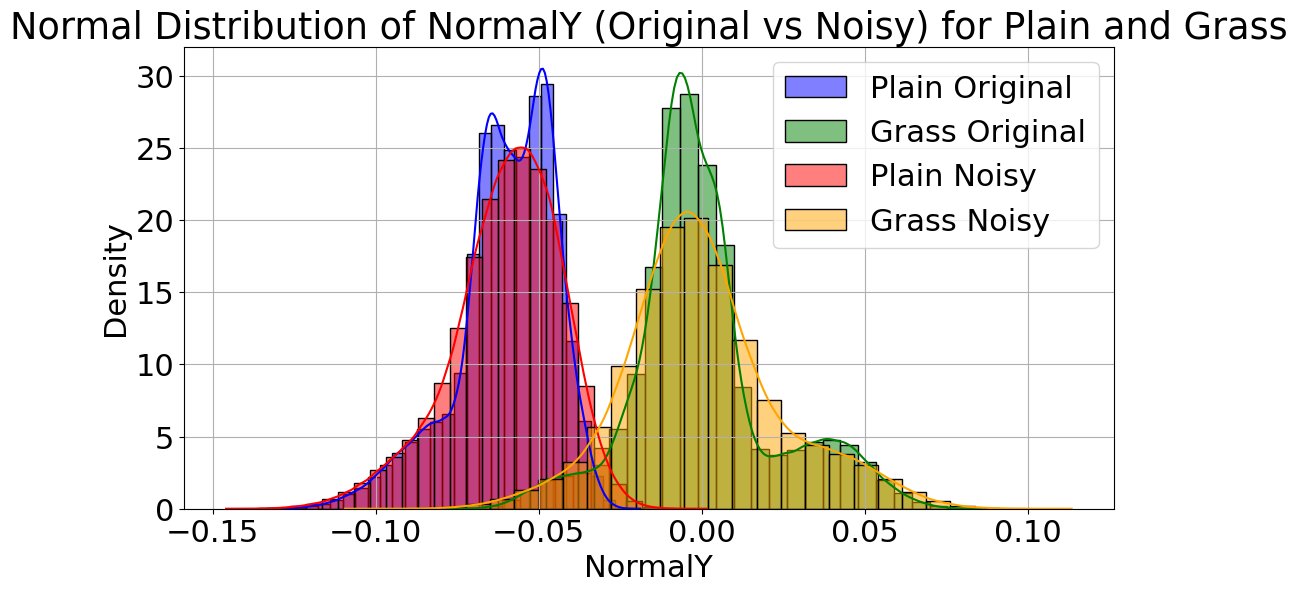

In [ ]:
# Plot histograms with KDE for NormalY and NormalY_noisy
plt.figure(figsize=(12, 6))

# Original NormalY for Plain and Grass
sns.histplot(plain_terrain_df['NormalY'], kde=True, bins=30, color='blue', label='Plain Original', stat='density')
sns.histplot(grass_terrain_df['NormalY'], kde=True, bins=30, color='green', label='Grass Original', stat='density')

# Noisy NormalY for Plain and Grass
sns.histplot(plain_terrain_df['NormalY_noisy'], kde=True, bins=30, color='red', label='Plain Noisy', stat='density', alpha=0.5)
sns.histplot(grass_terrain_df['NormalY_noisy'], kde=True, bins=30, color='orange', label='Grass Noisy', stat='density', alpha=0.5)

plt.title('Normal Distribution of NormalY (Original vs Noisy) for Plain and Grass')
plt.xlabel('NormalY')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
%matplotlib inline


In [ ]:
# Preparation of noisy data
# Ensure that combined_noisy_df is defined and has the appropriate structure
X_noisy = combined_noisy_df[['NormalX_noisy', 'NormalY_noisy']]
y_noisy = combined_noisy_df['label'].map({'plain': 0, 'grass': 1})

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_noisy, y_noisy, test_size=0.2, random_state=42)


In [ ]:
# Initialize the SVM model with RBF kernel
svm_rbf = SVC(kernel='rbf', C=1.0, gamma='scale', verbose=True)

# Train the model
svm_rbf.fit(X_train, y_train)

# Cross-validation to evaluate model performance
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cross_val_scores = cross_val_score(svm_rbf, X_train, y_train, cv=skf, n_jobs=-1)

print(f"Cross-Validation Accuracy: {cross_val_scores.mean():.4f} ± {cross_val_scores.std():.4f}")


Fitting 5 folds for each of 50 candidates, totalling 250 fits


/home/nrelab-titan/Desktop/shovon/.venv/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END ........C=22.273586212869027, gamma=10, kernel=rbf; total time=482.3min
[CV] END ........C=15.189814782062886, gamma=10, kernel=rbf; total time=483.9min
[CV] END ........C=15.189814782062886, gamma=10, kernel=rbf; total time=492.4min
[CV] END .........C=7.747586881130901, gamma=10, kernel=rbf; total time=493.9min
[CV] END .........C=7.747586881130901, gamma=10, kernel=rbf; total time=522.8min
[CV] END .........C=7.747586881130901, gamma=10, kernel=rbf; total time=526.4min
[CV] END ........C=22.273586212869027, gamma=10, kernel=rbf; total time=527.0min


In [ ]:
# Evaluate the model on the test set
y_pred = svm_rbf.predict(X_test)

# Calculate accuracy metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Display the metrics
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

# Generate a detailed classification report
class_report = classification_report(y_test, y_pred, target_names=['plain', 'grass'])
print("Classification Report:")
print(class_report)

# Plot Confusion Matrix
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['plain', 'grass'], yticklabels=['plain', 'grass'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for RBF SVM Model')
plt.show()


In [ ]:
# Evaluate the best model on the test set
y_pred = best_svm_model.predict(X_test)

# Calculate accuracy metrics
test_accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred, target_names=['plain', 'grass'])

print(f"Test Accuracy: {test_accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)


In [ ]:
# Save the accuracy and parameters to a DataFrame
results_df = pd.DataFrame({
    'C': [best_params['C']],
    'gamma': [best_params['gamma']],
    'kernel': [best_params['kernel']],
    'cross_val_accuracy': [best_score],
    'test_accuracy': [test_accuracy]
})

# Save the DataFrame to a CSV file
results_df.to_csv('svm_randomized_accuracy_results.csv', index=False)
print("Accuracy results saved to svm_randomized_accuracy_results.csv")


In [ ]:
# Plot Confusion Matrix
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['plain', 'grass'], yticklabels=['plain', 'grass'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Best SVM Model')
plt.show()
